In [9]:
%matplotlib inline
import matplotlib.pyplot as plt # biblioteca para fazer plots
from keras.datasets import cifar10 # base de ddos cifar10
import cv2 # # biblioteca para manipulação de imagem
import numpy as np # biblioteca de operações matriciais
import imutils 
from skimage.util import noise # funções para adição de ruídos
from skimage.feature import hog # funções para extração de features HOG
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten , Dense, Activation,Dropout
from tensorflow.keras.utils import to_categorical

# Conhecendo os dados

### Importando os dados

Essa base contem 60000 imagens, sendo dividida em 50000 para treino e 10000 para teste.

In [93]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#### Formato dos dados

In [14]:
print("Shape X_train:", X_train.shape, "\nShape X_test: ", X_test.shape, "\nShape y_train: ", y_train.shape, "\nShape y_test: ", y_test.shape)

Shape X_train: (50000, 32, 32, 3) 
Shape X_test:  (10000, 32, 32, 3) 
Shape y_train:  (50000, 1) 
Shape y_test:  (10000, 1)


### Plot das 50 primeiras imagens

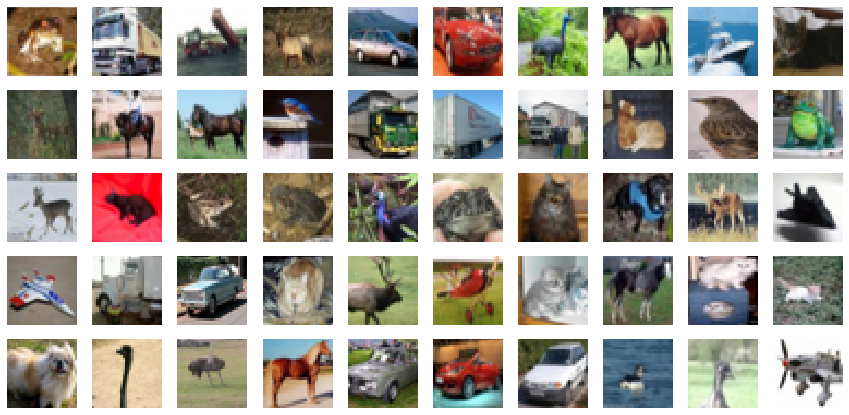

In [39]:
plt.figure(figsize=(15,15))
for i in range(1, 51):
    plt.subplot(5, 10, i), plt.imshow(X_train[i-1], interpolation='nearest'), plt.axis('off')

Essa é uma base de dados de imagem, sendo todas RGB, com dimensões de 32x32x3 (array dtype=uint8).

Existem 10 classes (6000 exemplos para cada classe), sendo que as labels das imagens estão em formato numérico e representam as seguintes classificações:

* 0: avião 
* 1: automóvel
* 2: passáro
* 3: gato
* 4: veado
* 5: cachorro
* 6: sapo
* 7: cavalo
* 8: navio
* 9: caminhão

In [62]:
# função para legenda da label
def classe_label(label):
    if label == 0: return "avião" 
    elif label == 1: return "automóvel"
    elif label == 2: return "passáro"
    elif label == 3: return "gato"
    elif label == 4: return "veado"
    elif label == 5: return "cachorro"
    elif label == 6: return "sapo"
    elif label == 7: return "cavalo"
    elif label == 8: return "navio"
    elif label == 9: return "caminhão"

Imagem com suas classes: 

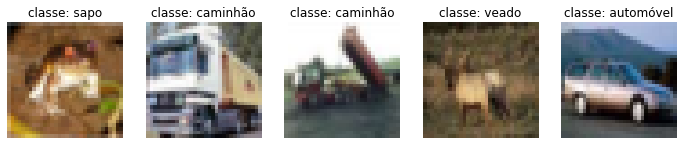

In [17]:
plt.figure(figsize=(12,5))
imagem = 0
while imagem < 5:
    plt.subplot(1, 5, imagem + 1), plt.imshow(X_train[imagem]), plt.axis('off'), plt.title("classe: " + classe_label(y_train[imagem]))
    imagem += 1

Amostra da classe sapo:

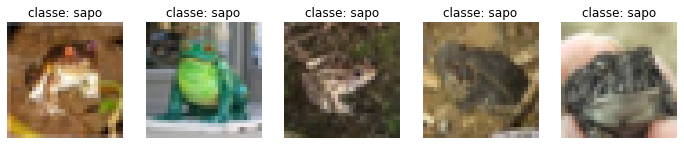

In [19]:
plt.figure(figsize=(12,5))
cont = 0
imagem = 0
while cont < 5:
    if y_train[imagem] == 6:
        plt.subplot(1, 5, cont + 1), plt.imshow(X_train[imagem]), plt.axis('off'), plt.title("classe: " + classe_label(y_train[imagem]))
        cont += 1
    imagem += 1

Essa base de dados não precisa de muitos tratamentos, dependendo da técnica que for usado para classificação não será necessário nenhum pré-processamento. Mas em outros casos, quando os dados não são organizados como essa base, é necessário a utilização de técnicas de `data augmentation`. 

# Data Augmentation

Vamos explorar algumas técnicas `data augmentation` que ajudam na extração de características relevantes das imagens. Essa abordagem permite gerar novos exemplares a partir das imagens já exitentes com o objetivo de aumentar a generalização do modelo, diminuindo o overfitting.

### Redimensionar

Para técnicas como CNN (Convolutional Neural Network), onde normalmente o input deve conter sempre as mesmas dimensões para todos os exemplos, redimensionar a imagem deve ser o primeiro passo a ser feito.

In [22]:
#leitura de um arquivo de imagem pelo OPENCV, por default o arquivo é lido no formato BGR
img = cv2.imread("imagens/gato.jpg")

#conversão de BGR para RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.

#redimensionar para o formato 600x600
img_resize = cv2.resize(img, (600, 600))

(<matplotlib.axes._subplots.AxesSubplot at 0x23e316babc8>,
 Text(0.5, 1.0, 'Redimensionada, (600, 600)'))

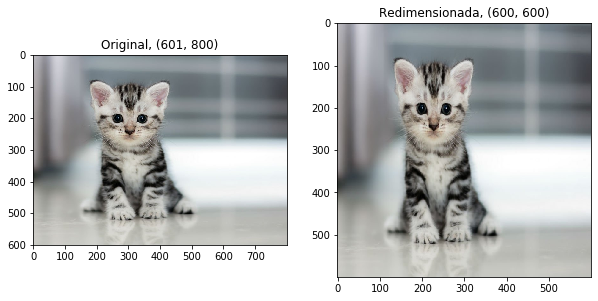

In [23]:
#plot das imagens
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1), plt.imshow(img), plt.title("Original, " + str(img.shape[0:2]))
plt.subplot(1, 2, 2), plt.imshow(img_resize), plt.title("Redimensionada, " + str(img_resize.shape[0:2]))

### Inverter

Uma rede neural deve aprender um objeto em qualquer posição, para isso vamos inverter a imagem para que ela apareça em diversos eixos. Com essa técnica buscamos diminuir o `bias` da base de treinamento.

(<matplotlib.axes._subplots.AxesSubplot at 0x23e319fde08>,
 <matplotlib.image.AxesImage at 0x23e317e3648>)

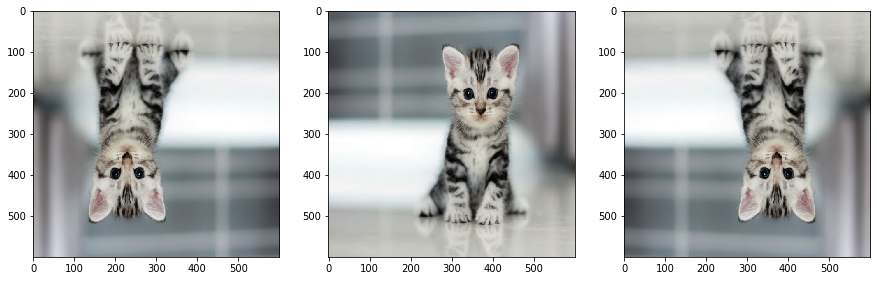

In [24]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1), plt.imshow(cv2.flip(img_resize, 0))
plt.subplot(1,3,2), plt.imshow(cv2.flip(img_resize, 1))
plt.subplot(1,3,3), plt.imshow(cv2.flip(img_resize, -1))

### Rotacionar

Com o mesmo objetivo da inversão, aqui buscamos ajustar a imagem em diversos ângulos.

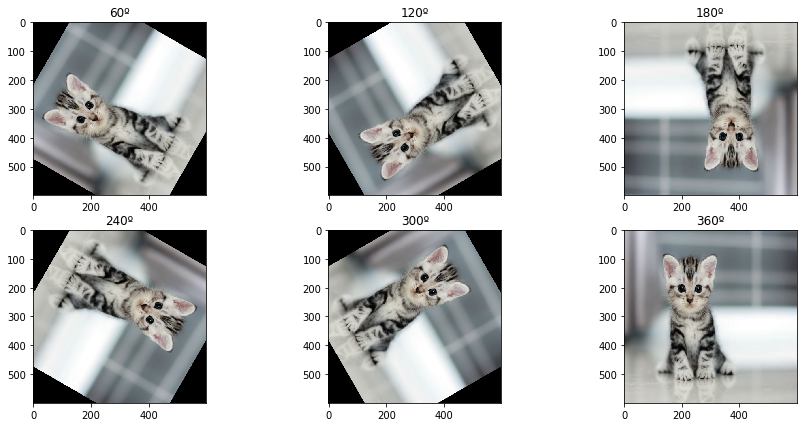

In [25]:
plt.figure(figsize=(15,7))

imagens_rotacionadas = []
cont = 1

for i in range(60, 361, 60):
    # aqui utilizamos a biblioteca imutils para rotacionar a imagem já que a função
    # rotate do opencv só permite rotacionar a imagem em 90, 180 e 270 graus. 
    plt.subplot(2,3,cont), plt.imshow(imutils.rotate(img_resize, i)), plt.title(str(i) + "º")
    cont += 1

### Escalonar

Como objetos podem aparecer em diferentes escalas em uma imagem no mundo real, vamos criar imagens que demonstram os mesmos objetos com diversos tamanhos. Escalonando conseguimos fazer com que partes do objeto não apareça, 'forçando' com que o algoritmo de aprendizagem consiga classificar nessas condições. 

In [41]:
# função para fazer o escalonamento das imagens
def escalonar(saida, proporcao):
    
    #cria uma cópia
    img = saida.copy()
    
    #cria uma imagem no formato que deve ser a saída
    saida = np.zeros(img.shape)
    
    #redimensiono a imagem de acordo com a proporção exemplificada
    img = cv2.resize(img, (int(img.shape[0] * proporcao), int(img.shape[1] * proporcao)))

    #se a redimensionada for menor que a imagem de saída ela será adicionada no centro da imagem
    if saida.shape[0] >= img.shape[0]:
        
        #calcula o x inicial onde a imagem será adicionada
        x = int((saida.shape[1] - img.shape[1]) / 2)
        #calcula o y inicial onde a imagem será adicionada
        y = int((saida.shape[0] - img.shape[0]) / 2)
        
        #insere a imagem no centro 
        saida[y:y+img.shape[0], x:x+img.shape[1]] = img
        
    else:
        
        #calcula o x inicial onde a imagem será cropada
        x = int((img.shape[1] - saida.shape[1]) / 2)
        #calcula o y inicial onde a imagem será cropada
        y = int((img.shape[0] - saida.shape[0]) / 2)
        
        saida = img[y:y+saida.shape[0], x:x+saida.shape[1]]
        
    return saida

In [27]:
imagens_escalonadas = []
cont = 0

# gera diversas imagens escalonadas com diversas proporções
for i in np.arange(0.25, 2.25, 0.25):
    imagens_escalonadas.append(escalonar(img_resize.copy(), i))
    cont += 1

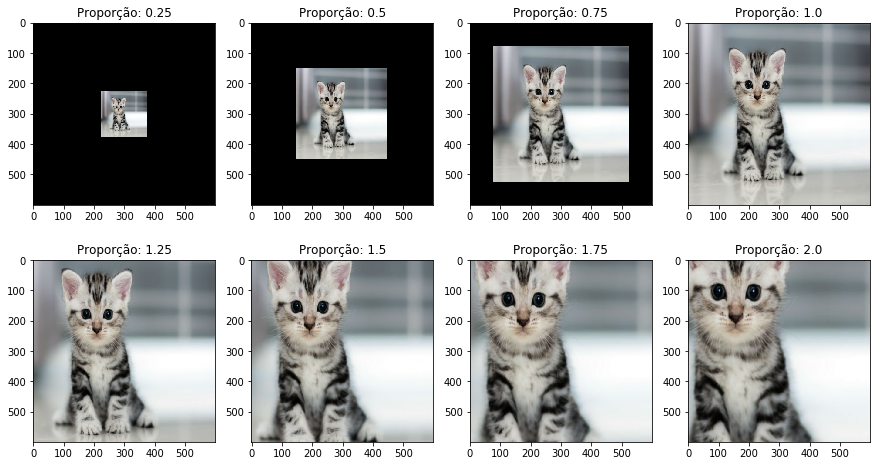

In [28]:
plt.figure(figsize=(15,8))
cont = 0

# faz o plot de todas as imagens escalonadas
for i in np.arange(0.25, 2.25, 0.25):
    plt.subplot(2, 4, cont + 1), plt.imshow(imagens_escalonadas[cont]), plt.title("Proporção: " + str(i))
    cont += 1

### Ruídos

Uma boa quantidade das imagem que estão disponíveis não estão 100% nítidas, assim incorporamos alguns ruídos para simular essas condições.

(<matplotlib.axes._subplots.AxesSubplot at 0x23e2ee39c08>,
 Text(0.5, 1.0, 'Ruído Sal e Pimenta'),
 (-0.5, 599.5, 599.5, -0.5))

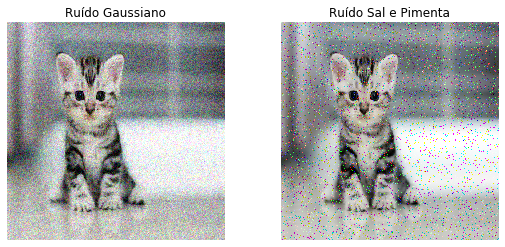

In [29]:
# vamos criar os ruídos com a função do scikit-image random_noise
img_gaussiana = noise.random_noise(img_resize, mode='gaussian')
img_sp = noise.random_noise(img_resize, mode="s&p")

# como as imagens são em 3 camadas, e a atribuição dos pontos são feitas randomicamente entre as camadas,
# os ruídos têm diversas cores
plt.figure(figsize=(9,4))
plt.subplot(1, 2, 1), plt.imshow(img_gaussiana), plt.title("Ruído Gaussiano"), plt.axis("off")
plt.subplot(1, 2, 2), plt.imshow(img_sp), plt.title("Ruído Sal e Pimenta"), plt.axis("off")

### Mover a imagem

Queremos que o objeto seja reconhecido em qualquer parte da imagem, com isso iremos posicioná-lo em diversos locais. Como no escalonamento, ao adicionar uma imagem em outro local tem a possibilidade que o objeto fique para "fora" da imagem, com issp forçando nosso modelo a aprender com esses obstáculos.

In [51]:
# função para mover a imagem nos 4 eixos
def mover_imagem(saida, posicao, proporcao):
    
    #posicao 1: topo
    #posicao 2: direita
    #posicao 3: inferior
    #posicao 4: esquerda
    
    #cria uma cópia
    img = saida.copy()
    
    #cria uma imagem no formato que deve ser a saída
    saida = np.zeros(img.shape)
    
    
    if posicao == 1:
        y = int(saida.shape[0] *  proporcao)
        saida[0:saida.shape[0] - y, 0:saida.shape[1]] = img[y:img.shape[0], 0:img.shape[1]]
    elif posicao == 2:
        x = int(saida.shape[1] *  proporcao)
        saida[0:saida.shape[0], x:saida.shape[1]] = img[0:img.shape[0], 0:img.shape[1]-x]
    elif posicao == 3:
        y = int(saida.shape[0] *  proporcao)
        saida[y:saida.shape[0], 0:saida.shape[1]] = img[0:img.shape[0] - y, 0:img.shape[1]]
    elif posicao == 4:    
        x = int(saida.shape[1] *  proporcao)
        saida[0:saida.shape[0], 0:saida.shape[1] - x] = img[0:img.shape[0], x:img.shape[1]]
    
    return saida

In [52]:
imagem_movida = []

for i in range(1, 5):
    imagem_movida.append(mover_imagem(img_resize.copy(), i, 0.3))

(<matplotlib.axes._subplots.AxesSubplot at 0x23e359cabc8>,
 (-0.5, 599.5, 599.5, -0.5),
 Text(0.5, 1.0, 'Direita'))

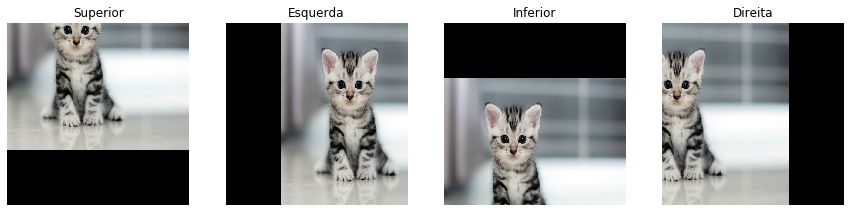

In [57]:
plt.figure(figsize=(15,8))

plt.subplot(1, 4, 1), plt.imshow(imagem_movida[0]), plt.axis("off"), plt.title("Superior")
plt.subplot(1, 4, 2), plt.imshow(imagem_movida[1]), plt.axis("off"), plt.title("Esquerda")
plt.subplot(1, 4, 3), plt.imshow(imagem_movida[2]), plt.axis("off"), plt.title("Inferior")
plt.subplot(1, 4, 4), plt.imshow(imagem_movida[3]), plt.axis("off"), plt.title("Direita")

##### Conclusão Data Augmentation

Podemos utilizar diversas técnicas como as apresentadas acima para tentar replicar as condições das imagens que lidamos no dia a dia. Outras abordagens como simular a luminosidade e perpectiva dos objetos são útei para adicionar mais características que buscamos que nossos modelos lidem.

Existe a possibilidade de combinar várias tratativas e criarmos outras que julgamos necessário. A abordagem que utilizaremos dependerá da solução que queremos utilizar para cada problema em específico.

Na bibioteca do `tensorflow` existe diversas funções que auxiliam na utilização de todas essas técnicas, de uma maneira automática. Dessa forma o trabalho é simplificado e as possibilidades de aplicações que você pode fazer são muito maiores.

Como o objetivo desse projeto não é a acurácia que vamos obter pelos modelos criados, e por motivos de poder computacional, não aplicaremos esses métodos na nossa base de dados do cinfar10 já que o número de amostras cresceria exponêncialmente.  

# Classificação do Dataset

Para a classificação utilizaremos 2 técnicas:
* A primeira será através da utilização de uma Freature Extraction com o objetivo de gerar features representativas das imagens e utilizar algoritmos de machine learning (Random Forest) para fazer a classificação da imagem. 
* O outro método (e mais robusto) será com o uso de CNN (Convolutional Neural Network) que tem se provado como um dos métodos mais eficases de classificação de imagens.

## Randrom Forest a partir da extração de features das imagens

### Feature Extraction

O que são features em uma imagem?

Nós temos muita facilidade de reconhecer objetos, isso se dá pela capacidade do nosso cérebro de reconhecer padrões e aprender o que eles significam. Isso ocorre de forma automática e não precisamos determinar quais são as características que utilizaremos para o reconhecimento, mas se pararmos para pensar conseguiremos definir algumas features que foram fundamentais para nosso aprendizado.



Para tentar dar essa capacidade de identificação para a máquina temos alguns métodos que podemos utilizar para extrair características:

* <b>Detecção de cantos</b>: 
    Certos objetos são fácilmente reconhecidos pelos padrões de seus cantos, como por exemplo um carro ter padrões de ângulos diferentes do que prédios, onde é normal ter muitos ângulos retos. Os padrões dos cantos podem ser significativos para a identificação de certos objetos. Uma vantagem de utilizar features cantos é que esse método não é sensível a rotação.<br>
    No OpenCV existem funções como goodFeaturesToTrack que escolhe os N melhores cantos da imagem, sendo ordenados de acordo com a qualidade e o FastFeatureDetector que utilizam técnicas de machine learning para detecção de cantos. Com essas informações é possível comparar os padrões dessas features dentre os objetos.

* <b>Keypoints em uma imagem</b>: 
    Um dos problemas da detecção de cantos é que ela é muito sensível ao tamanho da imagem, onde imagens pequenas e grandes não terão as mesmas representações de quinas. Para contornar esse problema o algoritmo SIFT utiliza filtros gaussianos com diversos valores de sigma para determinar os ponto nessas variações e determinar a máxima local entre eles como um canto. É utilizado técnicas de refinamento e é feito uma atribuição de orientação para que essa característica possa ser reconhecida independente da rotação do objeto.<br> 
    Outras variações de algoritmos veio após o SIFT como o SURF que é mais rápido e é um bom extrator de características.

* <b>HOG (Histogram of Oriented Gradients)</b>:
    HOG ele foca na forma e estutura do objeto e é usado para determinar o gradiente e a orientação dos pixéis. Com isso conseguimos determinar as bordas das imagens e, a partir de porções das imagens, pegamos os gradientes que a melhor representam. Diferentes dos métodos apresentados acima, HOG gera features para todas as posições da imagem, ao invés de pontos expecíficos.<br>
    Esse método já vem implementado na biblioteca scikit-image na função 'skimage.feature.hog'. Esse artigo https://www.learnopencv.com/histogram-of-oriented-gradients/ exemplifica todo o processo e como fazê-lo manualmente.

Existem outros métodos mas esses são uns dos mais utilizados.

Utilizarei o método HOG por ele ser amplamente utilizado no ramo de reconhecimento de objetos. Como exemplo de sua eficácia essa técnica também está foi utilizada e implementada no pacote `dlib`, na função 'dlib.get_frontal_face_detector()', onde features HOG de rostos foram extraídos para o treinamento de um detector de faces em imagens.

Utilzaremos a função hog do pacote skimage que retorna um vetor de features e a imagem representando essas features.


skimage.feature.hog, parâmetros principais:

* <b>orintations</b>: esse é o parâmetro que definirá o número de posições do gradiente para cada pixel. Alterar esse parâmetro fará com que mais ou menos posições da região do pixel seja levada em consideração para a votação de sua orientação do gradiente. Com valores muito pequenos pode se perder informação da região.

* <b>pixels_per_cell</b>: quantidade de pixels por célula. A imagem será separada em posições de acordo com os dados passados nesse parâmetro, por isso é importante estar de acordo com a dimensão da imagem. A ideia de usar células em vez de pixéis isolados é para reduzir a dimensionalidade e fazer que os resultados sejam menos sensíveis a ruídos. Nossas imagens têm dimensões de 32x32, então um input de 8x8 fará com que a imagem seja dividida em 16 regiões, sem perder informação. 

* <b>cells_per_block=(3, 3)</b>: quantidade de células por bloco. Esse tamanho irá definir a quantidade de features que serão extraídas pelas células. Essa informação também será utilizada na normalização do vetor do gradiente.

* <b>block_norm</b>: normalização do vetor de histograma por bloco, dividindo o vetor pela sua magnitude. Com isso conseguimos fazer com que os valores obtidos sejam invariantes a diferença de luminosidade. Assim a mesma imagens com constrate diferente tende a gerar os mesmos histogramas. Temos a opção de escolher a normalização L1 ou L2, onde a L1 pode zerar certos valores e a L2 diminui os valores mas não os zera.

* <b>transform_sqrt</b>: compactar a imagem. Não recomendado para imagens que possuem valores negativos.

Os parâmetros que utilizaresmo serão os: block_norm = "L2-Hys", orientations = 9, pixels_per_cell = [8, 8], cells_per_block = [3, 3]. Com esses parâmetros conseguiremos reduzir a dimensionalidade das features, e não perderemos informações de pixels que não serão cobertos pelas dimensões dos parâmetros. 

Extraíndo as features HOG da base de treino:

In [94]:
#extrai as features da base de treino
X_train_hog = []
for image in X_train:
    X_train_hog.append(hog(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), block_norm = "L2-Hys", orientations = 9, pixels_per_cell = [8, 8], cells_per_block = [3, 3]))

Extraíndo as features HOG da base de teste:

In [95]:
#extrai as features da base de teste
X_test_hog = []
for image in X_test:
    X_test_hog.append(hog(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), block_norm = "L2-Hys", orientations = 9, pixels_per_cell = [8, 8], cells_per_block = [3, 3]))

Com nossos parâmetros conseguimos extrair 324 features por imagem, (3 * 3 -> dimensões das células nos blocos) * (4 -> quantidade de blocos formados) * (9 -> direções que foram levadas em considerações para o histograma).

In [182]:
print("Shape X_train_hog:", [len(X_train_hog), len(X_train_hog[0])], "\nShape X_test_hog: ", [len(X_test_hog), len(X_test_hog[0])])

Shape X_train_hog: [50000, 324] 
Shape X_test_hog:  [10000, 324]


Aqui um exemplo das features para algumas imagens.

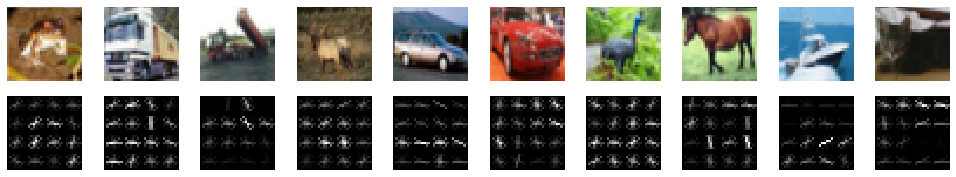

In [183]:
plt.figure(figsize=(17,3))
for i in range(0, 10):
    plt.subplot(2, 10, i+1), plt.imshow(X_train[i], interpolation='nearest'), plt.axis('off')
    _, img_hog = hog(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2GRAY), visualize=True, orientations = 9, pixels_per_cell = [8, 8], cells_per_block = [3, 3])
    plt.subplot(2, 10, i+11), plt.imshow(img_hog, interpolation='nearest', cmap="gray"), plt.axis('off')

### Modelagem com Random Forest

#### Por que Random Forest?

Random Forest é um algoritmo de Machine Learning supervisionado que utiliza o conceito Ensamble para criar diversas Árvores de Decisões aleatórias, cada um sendo treinado com features distintas. A classificação se dá a partir do voto majoritário dentre todos os classificadores. A ideia de treinar vários modelos 'fracos' é para garantir que cada um aprenda com informações diferentes e que ao juntar todo o conhecimento aprendido se possa chegar a uma conclusão mais acertiva. 

Ao juntar diversos modelos mais simples para fazer a classificação conseguimos evitar o overfitting mas perdemos o poder de interpretabilidade.

Como os dados que iremos utilizar são informações sobre os pixeis, sem fazer nenhum tratamento especial para cada classe, não há uma linearidade entre as features. Todos os pixéis foram levados em consideração para a extração das informações, então modelos como Regressão Logística e o SVM que funcionam muito bem com dados não lineares, podem ter dificuldades para classificar esse dataset. Algoritmo KNN que utiliza o conceito de distancia para a classificação poderia ser utilizado, mas como esse modelo não cria uma generalização dos dados, e sim armazena a base de treino para fazer o cálculo dos vizinhos, utilizar em uma base de dados de 50000 para treino com 324 dimensões pode ser muito custoso. Usar somente uma árvore de decisão faria com que ela fosse muito profunda e ajustar seus parâmetros seria complexo, com grande chance de gerar um overfitting.

Levando em considerações todos os aspectos apresentados escolhi o Random Forest por ser relativamente rápido e robusto, além de sempre estar presente em competições de Machine Learning com uma das melhores acurácias. Na biblioteca do scikit-learn existe uma implementação com a classe  `RandomForestClassifier()` e seus principais parâmetros são:

* n_estimators: quantidade de modelos que serão utilizados.
* criterion: critério de divisão dos nós. Existem 2 opções:
    * Gini: mede a impureza do nó
    * Entropy: mede o ganho de informação
* max_depth: a profundidade máxima de cada árvore.
* min_samples_split: quantidade mínima de registros por nó para se permitir a divisão do nó.
* min_samples_leaf: quantidade mínima de exemplos por folha.
* max_features: quantidade máxima de features utilizada por cada modelo.
* bootstrap: utilizar o Bootstrap para a criação do dataset de treinamento.
* class_weight: opção para balancear ou definir os pesos de cada classe.

Parâmetros como o max_depth, min_sample_split, min_sample_leafs... se bem configurados, ajudam a evitar o overfitting em uma árvore de decisão.  

Para simplificar nosso modelo vamos determinar somente os parametros n_estimators, criterion e max_depth. Para escolher os melhores valores para nossos hyperparâmetros utilizaremos o Cross Validation para criar um classificador com a melhor acurácia. A biblioteca sklearn possui a função GridSearchCV que executa toda a busca e determina os melhores hyperparametros que definimos para treinamento.

In [189]:
#criamos um dicionário com os hyperparâmetros que buscamos testar
hyperparametros = { "n_estimators":[10, 20, 30, 40], "criterion":["gini", "entropy"], "max_depth":[5, 10, 15, 20, 25, 30], "n_jobs":[-1]}

sg = GridSearchCV(RandomForestClassifier(), hyperparametros, cv = 5,verbose =10)
sg.fit(X_train_hog, y_train[:,0])

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] criterion=gini, max_depth=5, n_estimators=10, n_jobs=-1 .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=5, n_estimators=10, n_jobs=-1, score=0.335, total=   5.1s
[CV] criterion=gini, max_depth=5, n_estimators=10, n_jobs=-1 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, n_estimators=10, n_jobs=-1, score=0.329, total=   5.4s
[CV] criterion=gini, max_depth=5, n_estimators=10, n_jobs=-1 .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, n_estimators=10, n_jobs=-1, score=0.335, total=   5.6s
[CV] criterion=gini, max_depth=5, n_estimators=10, n_jobs=-1 .........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, n_estimators=10, n_jobs=-1, score=0.335, total=   5.5s
[CV] criterion=gini, max_depth=5, n_estimators=10, n_jobs=-1 .........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   21.5s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, n_estimators=10, n_jobs=-1, score=0.347, total=   5.4s
[CV] criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1 .........


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.9s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, score=0.355, total=   7.1s
[CV] criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1 .........


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   34.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, score=0.352, total=   7.1s
[CV] criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1 .........


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   41.1s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, score=0.362, total=   7.0s
[CV] criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1 .........


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   48.1s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, score=0.351, total=   7.8s
[CV] criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1 .........


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   55.9s remaining:    0.0s


[CV]  criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, score=0.359, total=   7.2s
[CV] criterion=gini, max_depth=5, n_estimators=30, n_jobs=-1 .........
[CV]  criterion=gini, max_depth=5, n_estimators=30, n_jobs=-1, score=0.373, total=   9.0s
[CV] criterion=gini, max_depth=5, n_estimators=30, n_jobs=-1 .........
[CV]  criterion=gini, max_depth=5, n_estimators=30, n_jobs=-1, score=0.361, total=   9.5s
[CV] criterion=gini, max_depth=5, n_estimators=30, n_jobs=-1 .........
[CV]  criterion=gini, max_depth=5, n_estimators=30, n_jobs=-1, score=0.371, total=  10.2s
[CV] criterion=gini, max_depth=5, n_estimators=30, n_jobs=-1 .........
[CV]  criterion=gini, max_depth=5, n_estimators=30, n_jobs=-1, score=0.362, total=   9.5s
[CV] criterion=gini, max_depth=5, n_estimators=30, n_jobs=-1 .........
[CV]  criterion=gini, max_depth=5, n_estimators=30, n_jobs=-1, score=0.375, total=   9.1s
[CV] criterion=gini, max_depth=5, n_estimators=40, n_jobs=-1 .........
[CV]  criterion=gini, max_depth=5,

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 137.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

Após a busca temos os melhores parâmetros dentre os testados.

In [190]:
sg.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

E a sua acurácia com a base de treino...

In [191]:
sg.best_score_

0.47154

Com isso vamos treinar o o modelo que encontramos.

In [96]:
modelo_rf = RandomForestClassifier(bootstrap=True, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
modelo_rf.fit(X_train_hog, y_train[:,0])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

#### Resultados

Com o modelo treinado vamos predizer as classes da base de teste e medir a sua acurácia com a classe metrics do scikit-learn.

In [97]:
predicao = modelo_rf.predict(X_test_hog)

In [196]:
print(metrics.classification_report(y_test[:, 0],predicao ))

              precision    recall  f1-score   support

           0       0.60      0.57      0.58      1000
           1       0.54      0.61      0.58      1000
           2       0.41      0.29      0.34      1000
           3       0.32      0.21      0.26      1000
           4       0.38      0.39      0.39      1000
           5       0.38      0.42      0.40      1000
           6       0.46      0.63      0.53      1000
           7       0.54      0.51      0.53      1000
           8       0.55      0.57      0.56      1000
           9       0.53      0.56      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.47      0.48      0.47     10000
weighted avg       0.47      0.48      0.47     10000



Obtivemos uma acurácia de 48% na base de teste com essa abordagem. 

As classes de automóveis(2) e de sapos(6) foram as que tiveram a maior a maior taxa de positivos verdadeiros(Recall) encontradas, porém a classe sapo teve uma grande taxa de falso positivos(precision). Com a métrica F1 temos as classes aviões(6) e automóveis(2) como a as que tiveram a melhor acurácia com esse modelo. 

As classes passáro(2) e gatos(6) foram as que tiveram a pior acurácia, ambas tendo somente 29% e 21% respectivamente de positivos verdadeiros(Recall) encontradas.

Text(0.5, 51.0, 'predito')

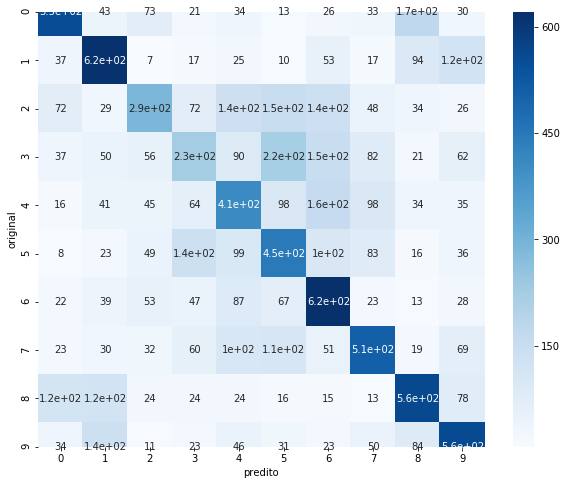

In [98]:
plt.figure(figsize=(10,8))
sns.heatmap(metrics.confusion_matrix(y_test[:, 0], predicao), cmap="Blues", annot=True)
plt.ylabel('original')
plt.xlabel('predito')

O mapa de calor acima da matriz de confusão da predição nos dá uma noção de como ficou a predição. Muitos gatos(3) foram classificados como cachorros(5), junto com veados(4) sendo classificados como sapos(6). Ambos automóveis(2) e sapos(6) tiveram uma grande correlação entre os valores verdadeiros e a predição, sendo as melhores taxas da métrica Recall.

### Exemplo de classificações

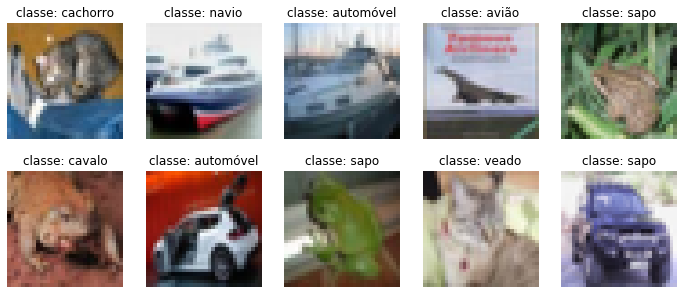

In [249]:
plt.figure(figsize=(12,5))
imagem = 0
while imagem < 10:
    plt.subplot(2, 5, imagem + 1), plt.imshow(X_test[imagem]), plt.axis('off'), plt.title("classe: " + classe_label(predicao[imagem]))
    imagem += 1

#### Conclusão Feature Extraction e Random Forest

Utilizando a técnica HOG para extração de feature das imagens não levamos em conta o contexto em si, mas somente as informações de todos os pixels. Como entre cada classe existem diversas maneiras de representar cada objeto é muito difícil utilizar as informações dos gradientes para determinar uma classe em específico. As imagens sendo pequenas faz com que tenhamos poucas características  as serem extraídas o que é mais uma dificuldade. 

Para melhorar a acurácia podemos utilizar outros extratores de características e combiná-los para gerar mais informações relevantes junto com técnicas como o PCA para reduzir a dimensionalidade dos dados e deixar o modelo mais simples. Nesse caso não apliquei técnicas de data augmentation mas seria uma das abordagens que poderia melhorar nossa performance.

## Redes Neurais Convolucionais

As redes neurais foram criadas na década de 50, mas por exigir um grande poder computacional os grandes avanços de suas utilizações vem na útima década, junto com o aprimoramento das GPUs. Durante seus diversos "invernos", técnicas foram criadas e aprimoradas e a que alavancou sua popularização e utilização foi o desenvolvimento do seu algoritmo de aprendizagem Backpropagation.  

O reconhecimento de imagem é um problema clássico da computação e seus melhores resultados vem com a utilização das CNN (Redes Neurais Convolucionais). Essa arquitetura de redes neurais tem as seguintes camadas:

* <b>Camada de Convolução</b>: é responsável pela utilização de filtros para extrair características da imagem(detecção de bordas, aguçamento, suavização…), auxiliando no aprendizado das informações.
* <b>Camada de Pooling</b>: tem o papel de reduzir a dimensionalidade da camada da imagem, mantendo somente as informações mais relevantes. É definido uma dimensão (2x2 por exemplo)  e qual informação será extraído dessa região, sendo o Max-Pooling um dos métodos mais utilizados.
* <b>Camada Densa</b>: sua entrada é o resultado das operações anteriores anteriores(Convolução ou Pooling), passando por uma camada que transforma os valores para 1 dimensão. Pode conter diversas camadas de neurônios conectados e sua saída possui N neurônios, sendo N o número de classes.

A função de ativação mais utilizada é a RELU, onde valores negativos tem valor 0 e valores positivos corrêspondem a uma função identidade.

([<matplotlib.lines.Line2D at 0x2c38d71adc8>], Text(0.5, 1.0, 'Função Relu'))

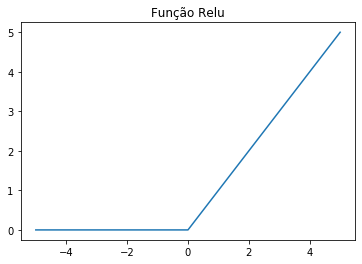

In [38]:
plt.plot([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], [0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5]), plt.title("Função Relu")

### Modelagem

Primeiro vamos normalizar a imagem para que seus valores fiquem entre 0 e 1. Após isso passaremos os valores das classes para um vetor, onde somente a posição que representa a classe da imagem ficará com valor 1.

In [10]:
#normalizando as imagens
X_train = X_train/255.
X_test = X_test/255.

y_test_original = y_test

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

A biblioteca mais utilizada para contrução de redes neurais é o `Tensorflow`, tendo o `keras` como uma API de alto nível para a contrução e treinamento de redes neurais.

A maneira mais fácil de se construir uma rede neural é com a classe Sequential(), com ela conseguimos adicionar sequencialmente as camadas da nossa rede.

As duas primeiras camadas adicionadas foram camadas de convolução com o método Conv2D() que cuida de todos os aspectos da camada convolucional, incluindo viés e ativação. Algum dos principais hyperparâmetros:

* filters: quantidade de filtros que aplicaremos por camadas, sendo 64 para a primeira e 32 para segunda.
* kernel_size: o tamanho do kernel dos filtros. Quanto maior o tamanho do kernel maior é a área utilizada para cada operação.
* padding: "same" adiciona um padding de zeros na imagem, assim a saída possui a mesma dimensão de width e height da entrada, "valid" performa as operações somente na imagem local, diminuindo a dimensão de saída.
* activation: função de ativação da camada. A função 'relu' faz com que valores negativos fiquem com valor 0.
* input_shape: o formato de entrada, no nosso caso será as dimensões da entrada.

In [44]:
modelo_cnn = Sequential()
modelo_cnn.add(Conv2D(filters=64, kernel_size =  (3, 3), padding ='same', activation = 'relu', input_shape = (32, 32, 3)))
modelo_cnn.add(Conv2D(filters=32, kernel_size = (3, 3), padding ='same', activation = 'relu', input_shape = (32, 32, 3)))

Seguindo com a construção da rede adicionaremos a camada de Pooling que irá reduzir a dimensionalidade das informações. O método MaxPooling2D utiliza o valor máximo da região expecificada. Hyperparâmetros:

* pool_size: área que será analisada para a redução de dimensionalidade. (2, 2) terá como saída uma dimensão de 16,16, com nossa imagem de 32x32.
* strides: como será feito o avanço da operação pool.
* padding: definirá se será adionado ou nao uma borda para fazer as operações na imagem.

Após a camada de pooling utilizamos o Dropout() com o valor de 0.2. A função do dropout é uma técnica de regularização que zera alguns pesos da nossa rede, no nosso caso 20% deles. Isso ajuda a evitar o overfitting.

In [45]:
modelo_cnn.add(MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid'))
modelo_cnn.add(Dropout(0.2))

Adicionarei mais 2 sequencias de camadas de Convolução, Pooling e Dropoout na rede.

In [46]:
modelo_cnn.add(Conv2D(filters=32, kernel_size = (3, 3), padding ='same', activation = 'relu', input_shape = (32, 32, 3)))
modelo_cnn.add(MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid'))
modelo_cnn.add(Dropout(0.2))
modelo_cnn.add(Conv2D(filters=32, kernel_size =  (3, 3), padding ='same', activation = 'relu', input_shape = (32, 32, 3)))
modelo_cnn.add(MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid'))
modelo_cnn.add(Dropout(0.2))

Com o método Flatten() todos valores passarão para um vetor de 1 dimensão, e terá uma dimensão de saída de 512x1 . Após isso mais 3 camadas densas serão adicionadas para fazer o aprendizado, sendo a ultima camada a de saída da rede. A a função de ativação da última camada será a 'softmax', onde todo o valor de saída por neurônio será de 0 até 1, sendo interpretado como a porcentagem de pertencimento da imagem para cada classe.

In [47]:
modelo_cnn.add(Flatten())
modelo_cnn.add(Dense(512, input_shape = (512, )))
modelo_cnn.add(Activation("relu"))
modelo_cnn.add(Dense(256, input_shape = (256, )))
modelo_cnn.add(Activation("relu"))
modelo_cnn.add(Dense(10))
modelo_cnn.add(Activation('softmax'))

Assim ficou o modelo construído:

In [39]:
modelo_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 32)         

### Treinamento

Depois da rede criada precisamos compilar o modelo. Os hyperparâmetros usados foram:
* optimizer: controla a taxa de aprendizado. Podemos criar um otimizador próprio, definindo a taxa de aprendizado e outros parâmetros, mas temos alguns já implementados como o 'adam', que ajusta a taxa de aprendizado de acordo com o treinamento.
* loss: função que mede a taxa de erro do modelo. Utilizaremos a 'categorical_crossentropy', que costumar performar bem com a classificação. Uma pontuação mais baixa um modelo mais acurado.
* metrics: define a métrica que será usada para comparar como o modelo está performando. Foi utilizado o "accuracy" para esse problema, mas caso uma classe fosse mais importante de ser encontrada que outra poderiamos utilizar outras métricas como o Recall.

In [48]:
modelo_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Para treinamento foi utilizado a base de treino (50000 exemplos), com 20% dela sendo usada para validação (10000 exemplos). O hyperparametro 'epochs' define a quantidade de vezes que a base será submetida para treinamento. 

In [49]:
historico = modelo_cnn.fit(X_train, y_train, validation_split=0.2, epochs=15)

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
40000/40000 [==============================] - 65s 2ms/sample - loss: 1.6392 - accuracy: 0.3945 - val_loss: 1.3768 - val_accuracy: 0.5117
Epoch 2/15
40000/40000 [==============================] - 61s 2ms/sample - loss: 1.2304 - accuracy: 0.5562 - val_loss: 1.0622 - val_accuracy: 0.6241
Epoch 3/15
40000/40000 [==============================] - 63s 2ms/sample - loss: 1.0750 - accuracy: 0.6148 - val_loss: 0.9707 - val_accuracy: 0.6587
Epoch 4/15
40000/40000 [==============================] - 62s 2ms/sample - loss: 0.9680 - accuracy: 0.6568 - val_loss: 0.8617 - val_accuracy: 0.6925
Epoch 5/15
40000/40000 [==============================] - 61s 2ms/sample - loss: 0.8989 - accuracy: 0.6818 - val_loss: 0.8262 - val_accuracy: 0.7084
Epoch 6/15
40000/40000 [==============================] - 61s 2ms/sample - loss: 0.8400 - accuracy: 0.7006 - val_loss: 0.7716 - val_accuracy: 0.7281
Epoch 7/15
40000/40000 [==============================] 

Após o treinamento temos as seguintes métricas:

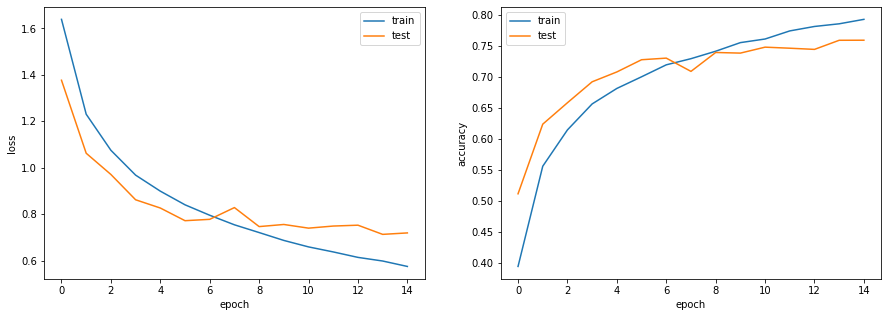

In [89]:
plt.figure(figsize=(15,5))

plt.subplot(1,2, 1)

plt.plot(historico.history["loss"])
plt.plot(historico.history["val_loss"],)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(1,2, 2)

plt.plot(historico.history["accuracy"])
plt.plot(historico.history["val_accuracy"])

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

A partir da época 6 vemos que o modelo continua se especificando na base de treinamento mas na base de validação a acurácia não tem um crescimento tão significativo. Isso demonstra um possível overfitting da nossa rede com mais épocas de treinamento.

### Predizendo a base de treino

In [55]:
predicao = modelo_cnn.predict_classes(X_test)

In [57]:
print(metrics.classification_report(y_test_original ,predicao ))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1000
           1       0.88      0.87      0.87      1000
           2       0.73      0.52      0.61      1000
           3       0.63      0.45      0.53      1000
           4       0.67      0.76      0.71      1000
           5       0.56      0.74      0.64      1000
           6       0.74      0.86      0.80      1000
           7       0.81      0.79      0.80      1000
           8       0.90      0.84      0.87      1000
           9       0.81      0.87      0.84      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



As classes com menor acurácia foram as dos pássaros(2) e dos gatos(3), com os valores de Recall (verdadeiro positivos) mais baixos. As classes que tiveram a maior acurácia foram os automóveis(8) e os navios(9) de acordo com a métrica F1.

Text(0.5, 51.0, 'predito')

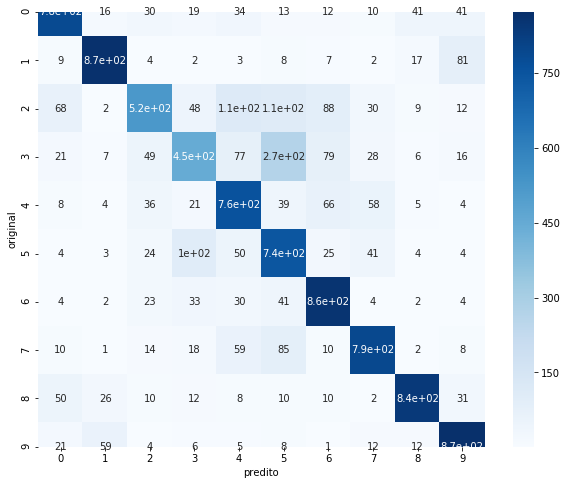

In [90]:
plt.figure(figsize=(10,8))
sns.heatmap(metrics.confusion_matrix(y_test_original ,predicao), cmap="Blues", annot=True)
plt.ylabel('original')
plt.xlabel('predito')

Vemos que a classe de pássaro em certos casos foram classificadas como veado(4) e cachorro(5) e a classe gato(3) teve bastante cassos que foram classificados como cachorro(5), indo de acordo com a métrica de Recall.

### Exemplos da classificação

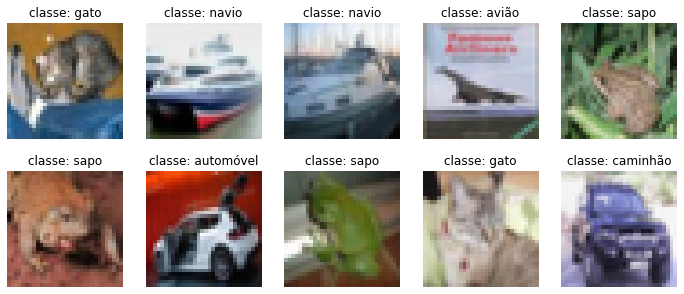

In [63]:
plt.figure(figsize=(12,5))
imagem = 0
while imagem < 10:
    plt.subplot(2, 5, imagem + 1), plt.imshow(X_test[imagem]), plt.axis('off'), plt.title("classe: " + classe_label(predicao[imagem]))
    imagem += 1

### Conclusão CNN

Rede Neural é uma técnica muito sofisticada e que com os anos tem se aprimorado junto com a capacidade computacional que ela necessita. Redes convolucionais se mostra muito eficiente lidando com imagens, e nesse caso não foi diferente. Com apenas 15 épocas de treinamento foi obtido uma acurácia de 75% na base de teste, mesmo com um modelo mais simples.

Para melhor acurácia podemos utilizar as técnicas de Data Augmentation para criar mais dados significantes das classe. A própria biblioteca do TensorFlow possui implementado esses procedimentos para facilitar o desenvolvimento. Outra abordagem seria ir para a academia, buscar e pesquisar melhores arquiteturas e criar novas redes, buscando e testando as melhores configurações que se adequem a esse problema.

# Conclusão do Projeto

A rede neural se mostrou ser uma técnica muito mais eficiênte e acurado para lidar com a classificação de imagens. Em apenas 1 época de treinamento ela foi capaz de atingir um nível de 51% de acurácia em relação a base de validação, comparados com 47% da Random Forest utilizando as features HOG. Mesmo se aplicar melhorias e extrair melhores características dos objetos, será muito difícil de métodos mais tradicionais rivalizarem com as redes neurais.

Todo esse desempenho vem com um custo. Para se treinar a rede foi gasto cerca de 20 minutos com uma GPU não tão robusta. Se comparado com o tempo de treinamento da Random Forest que levou alguns segundos, fazer testes e Cross Validation em uma rede é um trabalho muito custoso mas os resultados são muito superiores.

Com o aumento do poder computacional e aprimoramento de suas técnicas, as Redes Convolucionais serão cada vez mais usadas em diversos campos. Com as arquiteturas no estado da arte trazendo resultados muito superiores que as técnicas tradicionais, o seu uso trará grandes frutos para quaisquer ramo que for implementado. 